In [63]:
from torchvision import transforms,datasets
from torch.utils.data import DataLoader,random_split
import torch
import torch.nn as nn
import torch.optim as optim
import time
import torchvision.models as models
import matplotlib.pyplot as plt 

In [37]:
image_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(11),
    transforms.ColorJitter(brightness=0.2,contrast=0.2),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
])

### Data Loading

In [38]:
dataset_path = "./FRUIT-16K"
dataset = datasets.ImageFolder(root=dataset_path,transform=image_transforms)
len(dataset)

16000

In [39]:
dataset.classes

['F_Banana',
 'F_Lemon',
 'F_Lulo',
 'F_Mango',
 'F_Orange',
 'F_Strawberry',
 'F_Tamarillo',
 'F_Tomato',
 'S_Banana',
 'S_Lemon',
 'S_Lulo',
 'S_Mango',
 'S_Orange',
 'S_Strawberry',
 'S_Tamarillo',
 'S_Tomato']

In [40]:
classes_names=dataset.classes

In [41]:
len(classes_names)

16

In [42]:
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size   = int(0.15 * total_size)
test_size  = total_size - train_size - val_size

In [43]:
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [44]:
for images,labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


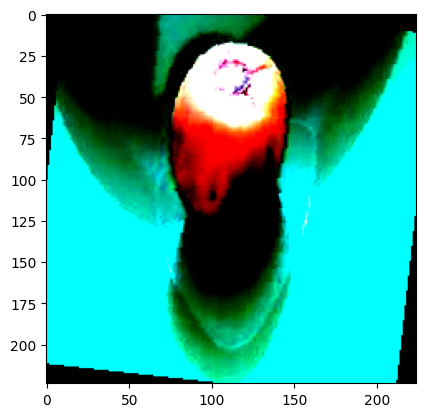

In [45]:
plt.imshow(images[0].permute(1,2,0))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


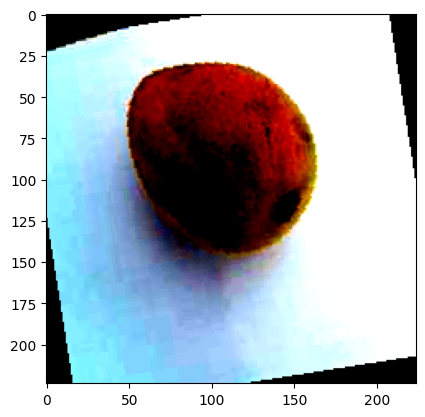

In [46]:

plt.imshow(images[1].permute(1,2,0))
plt.show()

## Model Training and validation

In [47]:
class fruitclassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),  # (16,224,224)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (16,112,112)

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),  # (32,112,112)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (32,56,56)

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),  # (64,56,56)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # (64,28,28)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc_layers(x)
        return x


In [48]:
model = fruitclassifierCNN(num_classes=16)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

In [49]:
def train_model(model, criterion, optimizer, train_loader, val_loader, test_loader, epochs=5):
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        correct_train = 0
        total_train = 0

        for batch_num, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy)

        print(f"Epoch [{epoch + 1}/{epochs}], Avg Loss: {epoch_loss:.4f}, Train Acc: {train_accuracy:.2f}%")

        # Validation
        model.eval()
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_accuracy = 100 * correct_val / total_val
        val_accuracies.append(val_accuracy)
        print(f"*** Validation Accuracy: {val_accuracy:.2f}% ***")

    # Final Test Accuracy
    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_accuracy = 100 * correct_test / total_test
    print(f"*** Final Test Accuracy: {test_accuracy:.2f}% ***")

    plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Train vs Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()


Epoch [1/10], Avg Loss: 1.3900, Train Acc: 53.04%
*** Validation Accuracy: 66.96% ***
Epoch [2/10], Avg Loss: 0.6042, Train Acc: 78.63%
*** Validation Accuracy: 83.83% ***
Epoch [3/10], Avg Loss: 0.3965, Train Acc: 86.16%
*** Validation Accuracy: 87.04% ***
Epoch [4/10], Avg Loss: 0.2960, Train Acc: 89.60%
*** Validation Accuracy: 89.38% ***
Epoch [5/10], Avg Loss: 0.2432, Train Acc: 91.93%
*** Validation Accuracy: 85.96% ***
Epoch [6/10], Avg Loss: 0.1806, Train Acc: 94.16%
*** Validation Accuracy: 90.88% ***
Epoch [7/10], Avg Loss: 0.1961, Train Acc: 93.43%
*** Validation Accuracy: 91.21% ***
Epoch [8/10], Avg Loss: 0.1628, Train Acc: 94.45%
*** Validation Accuracy: 92.29% ***
Epoch [9/10], Avg Loss: 0.1525, Train Acc: 94.94%
*** Validation Accuracy: 89.46% ***
Epoch [10/10], Avg Loss: 0.1349, Train Acc: 95.61%
*** Validation Accuracy: 94.42% ***
*** Final Test Accuracy: 94.08% ***


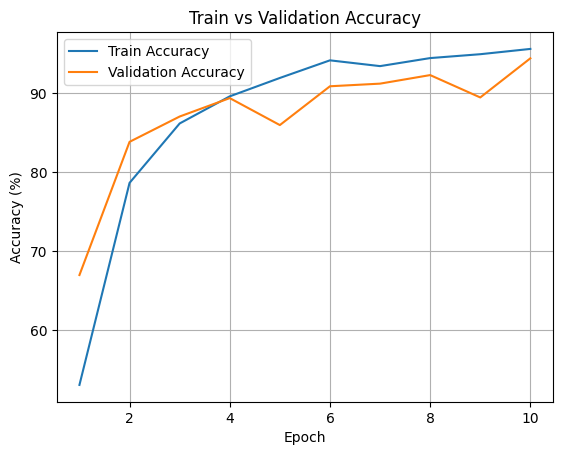

In [55]:
train_model(model, criterion, optimizer, train_loader, val_loader, test_loader, epochs=10)

In [56]:
torch.save(model.state_dict(),"model1.pth")

### Applying Regularization

In [55]:
class fruitclassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),# (16,224,224)
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (16,112,112)

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),  # (32,112,112)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (32,56,56)

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),  # (64,56,56)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # (64,28,28)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 28 * 28, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc_layers(x)
        return x


In [56]:
model = fruitclassifierCNN(num_classes=16)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

In [58]:
def train_model(model, criterion, optimizer, train_loader, val_loader, test_loader, epochs=5):
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        correct_train = 0
        total_train = 0

        for batch_num, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy)

        print(f"Epoch [{epoch + 1}/{epochs}], Avg Loss: {epoch_loss:.4f}, Train Acc: {train_accuracy:.2f}%")

        # Validation
        model.eval()
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_accuracy = 100 * correct_val / total_val
        val_accuracies.append(val_accuracy)
        print(f"*** Validation Accuracy: {val_accuracy:.2f}% ***")

    # Final Test Accuracy
    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_accuracy = 100 * correct_test / total_test
    print(f"*** Final Test Accuracy: {test_accuracy:.2f}% ***")

Epoch [1/5], Avg Loss: 3.4642, Train Acc: 16.46%
*** Validation Accuracy: 32.29% ***
Epoch [2/5], Avg Loss: 2.1435, Train Acc: 25.66%
*** Validation Accuracy: 39.08% ***
Epoch [3/5], Avg Loss: 1.9144, Train Acc: 31.12%
*** Validation Accuracy: 42.38% ***
Epoch [4/5], Avg Loss: 1.8036, Train Acc: 33.30%
*** Validation Accuracy: 48.71% ***
Epoch [5/5], Avg Loss: 1.7153, Train Acc: 35.71%
*** Validation Accuracy: 56.00% ***
*** Final Test Accuracy: 52.92% ***


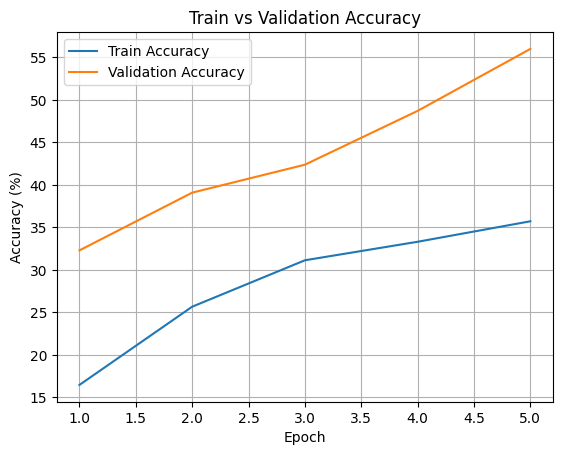

In [43]:
train_model(model, criterion, optimizer, train_loader, val_loader, test_loader, epochs=5)

## Transfer Learning with ResNet

In [59]:
class fruitClassificationResnet(nn.Module):
    def __init__(self,num_classes,dropout_rate=0.5):
        super().__init__()
        self.model = models.resnet50(weights='DEFAULT')

        ##  freezing the layers except the final layer in FC network
        for param in self.model.parameters():
            param.requires_grad=False

        for param in self.model.layer4.parameters():
            param.requires_grad=True

        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.model.fc.in_features,num_classes)
        )
    def forward(self,x):
        x=self.model(x)
        return x
        

In [60]:
model = fruitClassificationResnet(num_classes=16)
criterion=nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p:p.requires_grad,model.parameters()), lr=0.001)

In [61]:
train_model(model, criterion, optimizer, train_loader, val_loader, test_loader, epochs=1)

Epoch [1/1], Avg Loss: 0.1776, Train Acc: 95.19%
*** Validation Accuracy: 99.75% ***
*** Final Test Accuracy: 99.67% ***


In [62]:
torch.save(model.state_dict(),"ResNet50_model.pth")